# Flight Booking Exercise

## 1 Overview

We, BookFlight, are an online platform where users can find and book flights for different airlines. Users choose the flight via the BookFlight website/App and directly pay (via CreditCard or PayPal) on our platform. Before their flight, users need to check in via the airline’s website/app or via a self-service kiosk at the airport. Users, as long as not checked in, can void their flight booking via our website/app – we will then pay back the full money to the user.

To each airline, we send a Credit Note at the beginning of the month, covering all bookings for that airline for the previous month. We then pay the payment amount to the airline (as the user purchase the ticket via BookFlight and not directly via the airline).

## 2 Database Tables

<img src="table1.png" style="width: 600px;"/>
<img src="table2.png" style="width: 600px;"/>
<img src="table3.png" style="width: 600px;"/>



## Business Rules
* Credit notes and the respective payment are sent to all airlines at the first Tuesday of a calendar month

* A credit note contains all bookings where the flight end date is in the previous calendar month. Only bookings that are checked in and not voided must be on a credit note  

## Systems Overview & Considerations

<img src="system_overview.png" style="width: 500px;"/>

* The airline system connects to our host via a synchronous REST API
* The self-service kiosk has offline capability (due to bad internet connection at the airport). It gets all bookings of the next 48 hours from our host; the user can then check in even if the kiosk is offline. The kiosk submits an XML file with all checked in bookings to our host every 5min; in case of connectivity problems, it submits the XML file(s) as soon as it’s back online.

## Questions
Find example data in the attached Excel file.
1. Which inconsistencies/errors do you find in the data and how can you explain them?
2. Please write an SQL statement that ranks the September commission by passenger nationality
3. How would you handle the following request: “We want to know how many % of users who voided their flight did void within 2 days of buying the ticket. Please run a query to find out whether the %age differs per airline”

# Answers

To complete this exercise I used [Jupyter notebook](http://jupyter.org/), which is convenient interactive tool for documenting and presenting data analysis. I used Python to import the data and as a visualization tool, and sqlite3 as a database (open source). SQL magic extension (%%sql) allows to execute SQL queries in Jupyter.
For queries I also included alternative solutions, that can be used with commercial databases.

# Answer 1

### Inconsistencies / errors
* there is a _typo_ in Excel file in sheet name, an extra "o" in sheet name "Boooking"

### FlightStartUTC / FlightEndUTC datetime
* Values in FlightStartUTC datetime column are missing seconds record, FlightEndUTC datetimes include seconds
    - this can be due to different datetime format specified for the columns
* FlightStartUTC:
    - ID: 1 - possibly, flight start time not provided
    - IDs: 7, 13, 15 - possibly incomplete times, only hour provided
* FlightEndUTC:
    - ID: 25 - possibly, flight end time not provided

### Check if any passengers checked in and Status="voided"

In [2]:
%%sql

SELECT * FROM booking
WHERE checkedin like 'yes'
AND status like 'voided'

Done.


ID,FlightStartUTC,FlightEndUTC,PriceEUR,Commission,Status,VoidDate,Airline,PassengerNationality,CheckedIn
11,2017-09-07 07:12:00,2017-09-07 19:37:52,267.53,13.3765,voided,2017-09-06 20:36:44,Austrian,ITA,yes


This is most likely due to passenger using self-service kiosk to check in, and kiosk being offline at the time of check in. Check in is usually available 24 hours before the flight, and in this case VoidDate is less than 11 hours before the flight. If the kiosk was offline for longer time period, it is possible that the passenger managed to check in, and then voided the ticket, most likely via an app on mobile connection, before kiosk re-established internet connection.

### Has anyone missed their flight?

In [3]:
%%sql

SELECT * FROM booking
WHERE checkedin like 'no'
AND voiddate IS null

Done.


ID,FlightStartUTC,FlightEndUTC,PriceEUR,Commission,Status,VoidDate,Airline,PassengerNationality,CheckedIn
2,2017-08-23 21:36:00,2017-08-25 05:14:29,91.03,4.5515,issued,None,BA,AUT,no
3,2017-09-23 02:24:00,2017-09-24 00:01:44,359.35,17.9675,issued,None,Qatar,GER,no
6,2017-08-30 07:12:00,2017-08-31 09:45:27,548.3,27.415,issued,None,Qatar,FRA,no
9,2017-08-19 04:48:00,2017-08-20 09:24:41,451.89,22.5945,issued,None,BA,USA,no


Looks like 4 passengers paid the flight, didn't make it to check in, and did not void the booking.

### Is there any deviations in commission

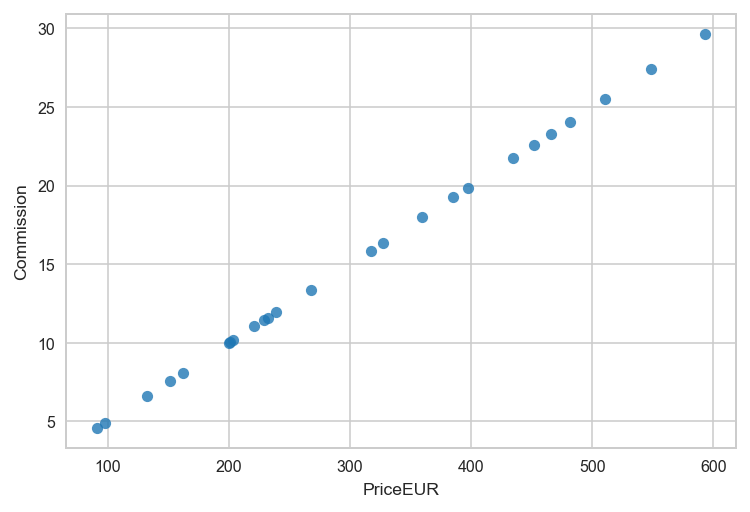

In [4]:
sns.regplot(x="PriceEUR", y="Commission", data=booking, fit_reg=False)

Commission is at constant 5% rate.

## CreditNote
* PaymentDate not included
* CreditNote covers 2 months - should be one month only.
* the only correct PaymentAmount value on CreditNote was payment for Austrian in August. All other values were wrong due to incorrect query:
    - Wrong datetime field (FlightStartUTC) chosen as indicator of payment period (should be FlightEndUTC).
    - Voided bookings not excluded.
    - Only checked in passengers included (payment should be made on all non-voided transactions).

In [5]:
%%sql

-- example of incorrect query that may have been used to generate the CreditNote (simplified for clarity)

SELECT
    airline,
    CASE 
        WHEN flightstartutc BETWEEN '2017-08-01 00:00:00' AND '2017-08-31 23:59:59'
        THEN 'August'
        WHEN flightstartutc BETWEEN '2017-09-01 00:00:00' AND '2017-09-30 23:59:59'
        THEN 'September'
        ELSE 'other month'
        END AS 'PaymentMonth',
        SUM(priceeur-commission) as PaymentAmount
FROM booking
WHERE checkedin = 'yes'
GROUP BY
    paymentmonth,
    airline;

Done.


Airline,PaymentMonth,PaymentAmount
Austrian,August,747.821
BA,August,821.9875
Qatar,August,283.2805
Austrian,September,1495.585
BA,September,692.816
Qatar,September,867.464


In [6]:
%%sql

-- corrected query (first Tuesday of month can be coded as function rather than static value,
-- also PeriodStart, PeriodEnd replaced here with PaymentMonth to shorten code,
-- both August and September included)

SELECT
    airline,
    CASE 
        WHEN flightendutc BETWEEN '2017-08-01 00:00:00' AND '2017-08-31 23:59:59'
        THEN '2017-08-01'
        WHEN flightendutc BETWEEN '2017-09-01 00:00:00' AND '2017-09-30 23:59:59'
        THEN '2017-09-05'
        ELSE 'other month'
        END AS 'PaymentDate',
    CASE 
        WHEN flightendutc BETWEEN '2017-08-01 00:00:00' AND '2017-08-31 23:59:59'
        THEN 'August'
        WHEN flightendutc BETWEEN '2017-09-01 00:00:00' AND '2017-09-30 23:59:59'
        THEN 'September'
        ELSE 'other month'
        END AS 'PaymentMonth',
        SUM(priceeur-commission) as PaymentAmount
FROM booking
WHERE status != 'voided'
GROUP BY
    paymentmonth,
    airline;

Done.


Airline,PaymentDate,PaymentMonth,PaymentAmount
Austrian,2017-08-01,August,747.821
BA,2017-08-01,August,1128.087
Qatar,2017-08-01,August,804.1655
Austrian,2017-09-05,September,1241.4315
BA,2017-09-05,September,902.4905
Qatar,2017-09-05,September,1208.8465


## Answer 2
Please write an SQL statement that ranks the September commission by passenger nationality

In [7]:
%%sql

SELECT
    passengernationality,
    ROUND(SUM(commission),2) as Commission
FROM booking
WHERE FlightEndUTC BETWEEN '2017-09-01 00:00:00' AND '2017-09-30 23:59:59'
AND status != 'voided'
GROUP BY passengernationality
ORDER BY passengernationality;

Done.


PassengerNationality,Commission
AUT,35.67
FRA,61.4
GER,32.69
ITA,11.6
USA,35.1


* Solution above ranks commission by passenger nationality, adding rank numbers is a little cumbersome in sqlite, in commercial databases (MS/Oracle) we could use RANK() to do just that.

In [ ]:
%%sql

SELECT
    commission,
    passengernationality,
    RANK() OVER (ORDER BY passengernationality) as Rank
FROM booking;
WHERE FlightEndUTC BETWEEN '2017-09-01 00:00:00' AND '2017-09-30 23:59:59'
AND status != 'voided';

## Answer 3
How would you handle the following request: “We want to know how many % of users who voided their flight did void within 2 days of buying the ticket. Please run a query to find out whether the %age differs per airline”

* I assume that booking database/host system has a "Purchase" table where purchase details are recorded. "Purchase" table at minimum has transaction datetime unique ID for every transaction, same ID number is used in the "Booking" table for corresponing bookings.

In [ ]:
%%sql

-- sqlite3 syntax for datetime difference calculation used

- part_1

WITH t1 (ID, Airline, VoidTime) as (
SELECT
    b.id as id,
    b.airline,
    CASE 
        WHEN CAST(strftime('%s',b.voiddate)-strftime('%s',p.purchasedate) as float)/60/60/24 <=2
        THEN 'early'
        ELSE 'late'
        END AS 'VoidTime'
FROM 
    booking b, 
    purchase p
WHERE 
    b.status ='voided'
AND 
    b.id = p.id
GROUP BY
    b.id, airline, voidtime)


-- part_2

SELECT
    t1.airline,
    t1.voidtime,
    CAST(COUNT(*) as float)/t2.total*100 as Percentage
FROM
    t1,(
        SELECT
            airline,
            COUNT(voidtime) as total
        FROM 
            t1
        GROUP BY
            airline
        ) as t2
WHERE
    t1.airline = t2.airline
GROUP BY
    t1.airline, t1.voidtime;

#### Alternative part_2 query (uses functions available in commercial databases)

In [ ]:
%%sql

--part_2

SELECT
    airline,
    voidtime,
    COUNT(*) / CAST(SUM(count(*)) OVER (PARTITION BY airline) as float)*100
FROM t1
GROUP BY
    airline,
    voidtime

In [1]:
'''
Python code used to load data from Excel to SQL database
'''

import pandas as pd
import sqlite3 as db
import matplotlib.pyplot as plt
import matplotlib.style
import seaborn as sns


# matplotlib and seaborn config (graphic output)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
sns.set_context('paper')

# parsing data from Excel to pandas dataframe
xls = pd.ExcelFile("./original_files/Exercise.xlsx")
booking = xls.parse('Boooking')
creditnote = xls.parse('CreditNote')

# removes milliseconds from FlightEndUTC datetime (added on import due to approx. of float values)
booking.FlightEndUTC = booking.FlightEndUTC.values.astype('<M8[s]')

# create database cursor
conn = db.connect("exercise.db")
conn.text_factory = str
c = conn.cursor()

# create tables
c.execute('''CREATE TABLE Booking (
    ID INT PRIMARY KEY NOT NULL,
    FlightStartUTC INTEGER,
    FlightEndUTC INTEGER,
    PriceEUR FLOAT,
    Commission FLOAT,
    Status TEXT,
    VoidDate INTEGER,
    Airline TEXT,
    PassengerNationality TEXT,
    CheckedIn TEXT
);''')

c.execute('''CREATE TABLE CreditNote (
CreditNoteNo INT PRIMARY KEY NOT NULL,
Airline TEXT,
PaymentDate TEXT,
PeriodStart TEXT,
PeriodEnd TEXT,
PaymentAmount FLOAT
);''')

# load data to database
booking.to_sql('Booking', conn, if_exists='append', index=False)
creditnote.to_sql('CreditNote', conn, if_exists='append', index=False)

# loads the SQL magic extensions
%load_ext sql

#connect database
%sql sqlite:///exercise.db

u'Connected: None@exercise.db'